## Import libraries

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats 
import warnings
warnings.filterwarnings("ignore") 

## Data Inspection/ Preprocessing

In [3]:
# Read in data
df = pd.read_csv('all_data.csv')
df

,Country,Year,Life expectancy at birth (years),GDP
0,Chile,2000,77.3,7.786093e+10
1,Chile,2001,77.3,7.097992e+10
2,Chile,2002,77.8,6.973681e+10
3,Chile,2003,77.9,7.564346e+10
4,Chile,2004,78.0,9.921039e+10
...,...,...,...,...
91,Zimbabwe,2011,54.9,1.209845e+10
92,Zimbabwe,2012,56.6,1.424249e+10
93,Zimbabwe,2013,58.0,1.545177e+10
94,Zimbabwe,2014,59.2,1.589105e+10


In [11]:
# Check null, unique values

df.isna().sum() # data shows no missing values
df.Country.unique()

array(['Chile', 'China', 'Germany', 'Mexico', 'United States of America',
       'Zimbabwe'], dtype=object)

In [12]:
df.Year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015], dtype=int64)

In [216]:
# Expected 16 values for each country, based on unique years
df.Country.value_counts()

Mexico                      16
United States of America    16
China                       16
Chile                       16
Zimbabwe                    16
Germany                     16
Name: Country, dtype: int64

In [217]:
# Drop duplicate instances of country and year, incase of any - no rows were dropped
df.drop_duplicates(subset=['Country', 'Year'], inplace=True)
df

,Country,Year,life_exp,GDP
0,Chile,2000,77.3,7.786093e+10
1,Chile,2001,77.3,7.097992e+10
2,Chile,2002,77.8,6.973681e+10
3,Chile,2003,77.9,7.564346e+10
4,Chile,2004,78.0,9.921039e+10
...,...,...,...,...
91,Zimbabwe,2011,54.9,1.209845e+10
92,Zimbabwe,2012,56.6,1.424249e+10
93,Zimbabwe,2013,58.0,1.545177e+10
94,Zimbabwe,2014,59.2,1.589105e+10


In [13]:
# Rename columns
df.rename(columns={'Life expectancy at birth (years)': 'life_exp'}, inplace=True)
df

,Country,Year,life_exp,GDP
0,Chile,2000,77.3,7.786093e+10
1,Chile,2001,77.3,7.097992e+10
2,Chile,2002,77.8,6.973681e+10
3,Chile,2003,77.9,7.564346e+10
4,Chile,2004,78.0,9.921039e+10
...,...,...,...,...
91,Zimbabwe,2011,54.9,1.209845e+10
92,Zimbabwe,2012,56.6,1.424249e+10
93,Zimbabwe,2013,58.0,1.545177e+10
94,Zimbabwe,2014,59.2,1.589105e+10


## Exploratory Data Analysis

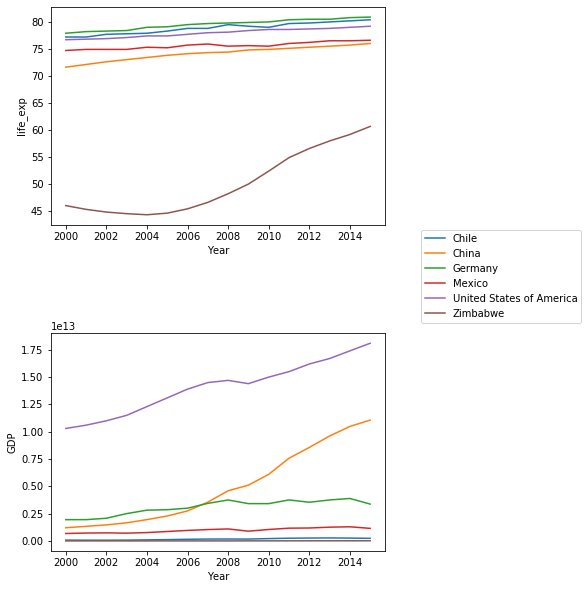

In [57]:
plt.figure(figsize=(6,10))

plt.subplot(2, 1, 1)
sns.lineplot(data=df, x='Year', y='life_exp', hue='Country')
plt.legend(bbox_to_anchor=(1.6,0))

plt.subplot(2, 1, 2)
ax = sns.lineplot(data=df, x='Year', y='GDP', hue='Country')
ax.legend_.remove()
plt.subplots_adjust(hspace=0.5)

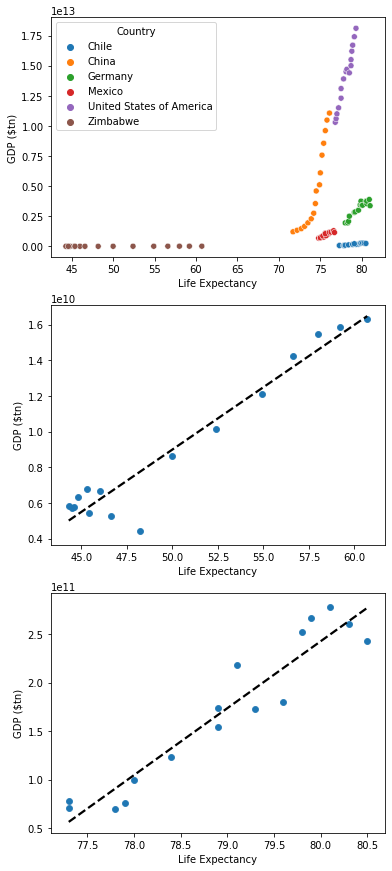

In [71]:
plt.figure(figsize=(6, 15))

plt.subplot(3, 1, 1)
sns.scatterplot(data=df, x='life_exp', y='GDP', hue='Country')
plt.xlabel('Life Expectancy')
plt.ylabel('GDP ($tn)')


# from the plot below, there is no overall linear relationship between GDP and life expectancy.
# When clustered by country however, we see clear patterns. Therefore, the linear model can be developed at a country 
# level. Before we do that however, let's zoom in on Zimbabwe to check if scaling is misrepresenting the data

plt.subplot(3, 1, 2)
sns.scatterplot(data=df[(df['Country']=='Zimbabwe')], x='life_exp', y='GDP')
sns.regplot(data=df[(df['Country']=='Zimbabwe')], x='life_exp', y='GDP', line_kws={'ls':'--', 'color':'black'}, ci=None)
plt.xlabel('Life Expectancy')
plt.ylabel('GDP ($tn)')

# Now we have a visual that is a much clearer representation of the GDP-life expectancy relationship for Zimbabwe. Lets do
# the same for Chile

plt.subplot(3, 1, 3)
sns.scatterplot(data=df[(df['Country']=='Chile')], x='life_exp', y='GDP')
sns.regplot(data=df[(df['Country']=='Chile')], x='life_exp', y='GDP', line_kws={'ls':'--', 'color':'black'}, ci=None)
plt.xlabel('Life Expectancy')
plt.ylabel('GDP ($tn)')

plt.show()

In [86]:
# One thing to note from the above is that Zimbabwe looks like an outlier, in that life expectancy seems to be
# independent of GDP. Let's check the correlation between life expectancy and GDP by country

ind = df.Country.unique()

corr_df = pd.DataFrame(columns=['Country', 'GDP_LE_Correlation'], index=range(6))

for count, country in enumerate(ind):
    corr_df.iloc[count, 0] = country
    corr, r = stats.pearsonr(df[df.Country == country].GDP, df[df.Country == country].life_exp)
    corr_df.iloc[count, 1] = corr

corr_df

# We can now confirm that the correlation between GDP and life expectancy is strong for all countries

,Country,GDP_LE_Correlation
0,Chile,0.949877
1,China,0.908526
2,Germany,0.932699
3,Mexico,0.932238
4,United States of America,0.981709
5,Zimbabwe,0.9662


In [87]:
# Next I want to see the time series relationship for both GDP and life expectancy. This is to decide what should be the 
# independent variable when running the regression. If there is one variable we can more easily predict using linear
# regression over time, we can subsequently use that to predict the other

time_corr = pd.DataFrame(columns=['Country', 'GDP', 'LE'], index=range(6))

for count, country in enumerate(ind):
    time_corr.iloc[count, 0] = country
    
    corr, r = stats.pearsonr(df[df.Country == country].Year, df[df.Country == country].GDP)
    time_corr.iloc[count, 1] = corr
    
    corr, r = stats.pearsonr(df[df.Country == country].Year, df[df.Country == country].life_exp)
    time_corr.iloc[count, 2] = corr

time_corr    

# Generally speaking it looks like life expectancy has the superior correlation over time. However common sense dictates 
# that GDP is more likely to impact life expectancy than the other way around, since GDP will impact quality of life,
# income levels, crime, and other social aspects, which will in turn affect life expectancy. The correlations look strong
# enough that it can be used for linear regression

,Country,GDP,LE
0,Chile,0.962289,0.980543
1,China,0.969447,0.982734
2,Germany,0.894334,0.987377
3,Mexico,0.937087,0.950451
4,United States of America,0.990047,0.992312
5,Zimbabwe,0.837532,0.923924


## Linear regressions assumptions

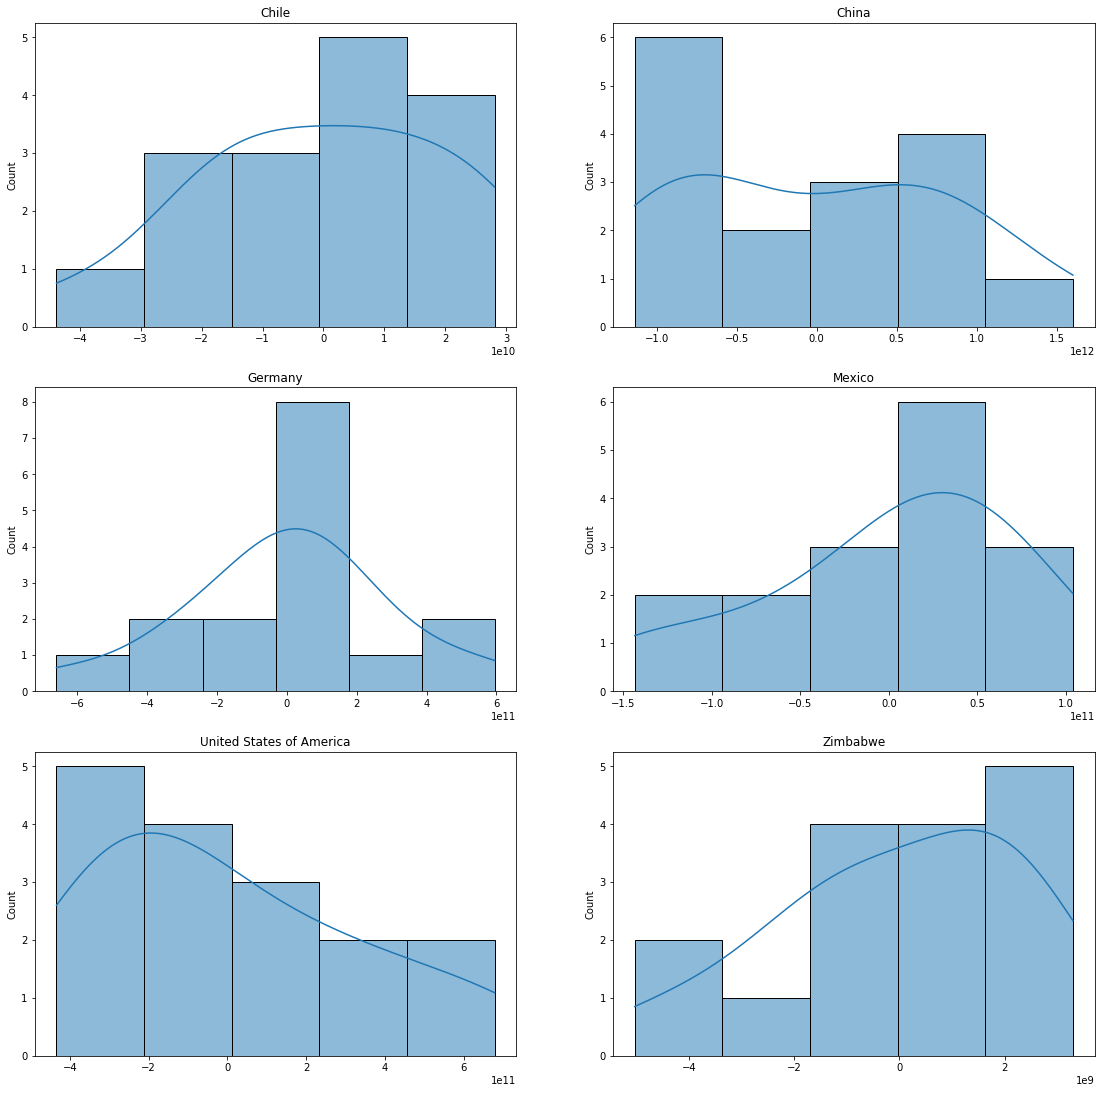

In [204]:
# Let's now check that the assumptions of linear regression (Year-GDP) are met.
# First let's test the distribution of the residuals.

fig, ax = plt.subplots(3, 2, figsize=(19, 19))

row = 0
col = 0

for count, country in enumerate(ind):
    df_subset = df[df.Country == country]
    model = sm.OLS.from_formula('GDP ~ Year', data=df_subset)
    results = model.fit()
    fitted_values = results.predict(df_subset)
    residuals = df_subset['GDP'] - fitted_values
    
#     if count == 0:
#         row = 0
#         col = 0
    sns.histplot(ax=ax[row, col], x=residuals, kde=True)
    ax[row, col].set_title(country)
    if col == 1:
        col = 0
        row += 1
    else:
        col += 1
        
# from the plots, it seems normality of residuals is violated in some cases

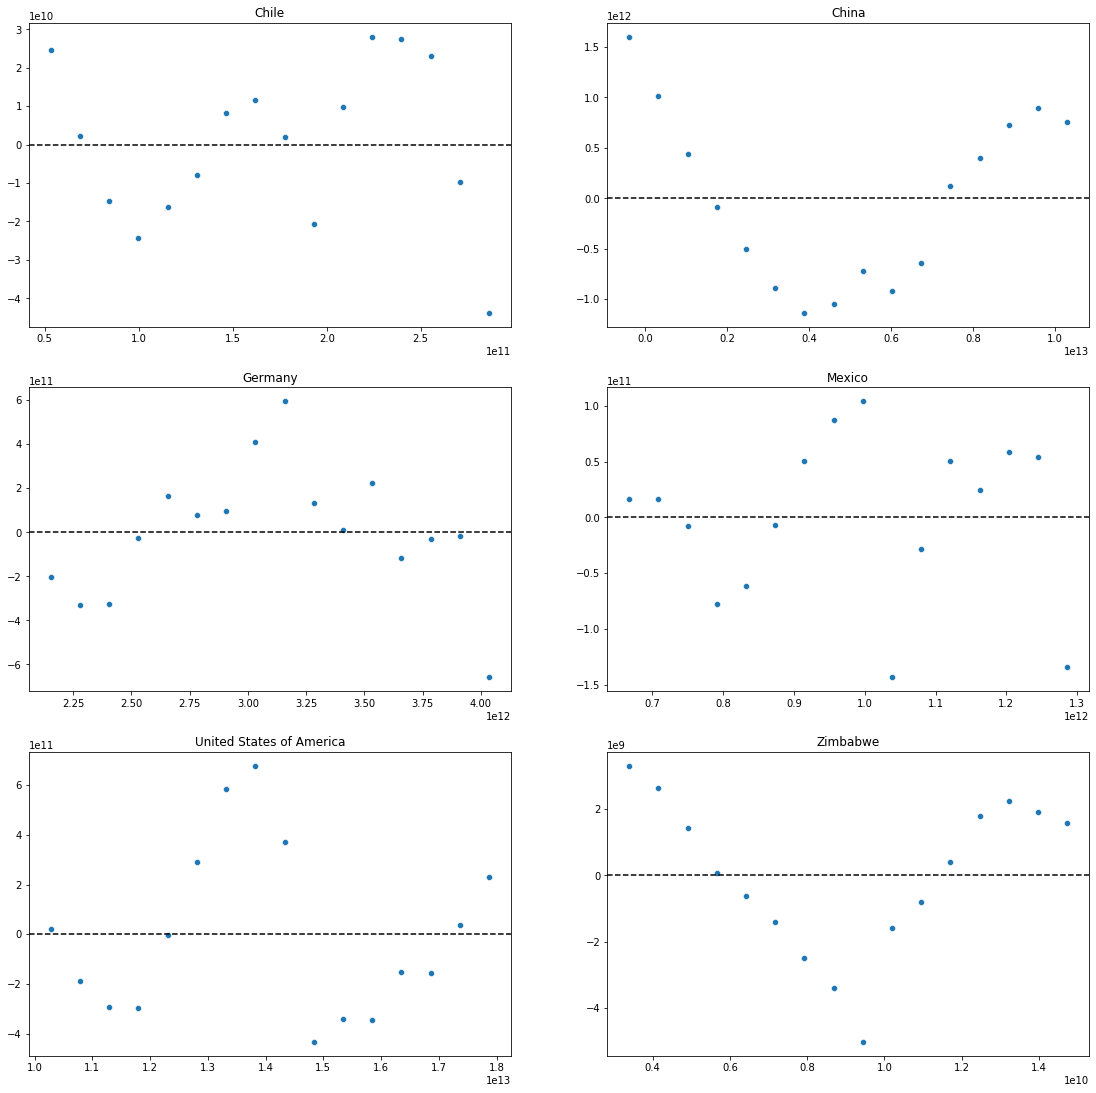

In [203]:
fig, ax = plt.subplots(3, 2, figsize=(19, 19))

row = 0
col = 0

for count, country in enumerate(ind):
    df_subset = df[df.Country == country]
    model = sm.OLS.from_formula('GDP ~ Year', data=df_subset)
    results = model.fit()
    fitted_values = results.predict(df_subset)
    residuals = df_subset['GDP'] - fitted_values
    
#     if count == 0:
#         row = 0
#         col = 0
    sns.scatterplot(ax=ax[row, col], x=fitted_values, y=residuals)
    ax[row, col].axhline(y=0, color='black', ls='--')
    ax[row, col].set_title(country)
    if col == 1:
        col = 0
        row += 1
    else:
        col += 1
        
# from the plots below, the assumption of homoscedacity looks to be violated for some countries

### Linear regression assumptions with log transformation

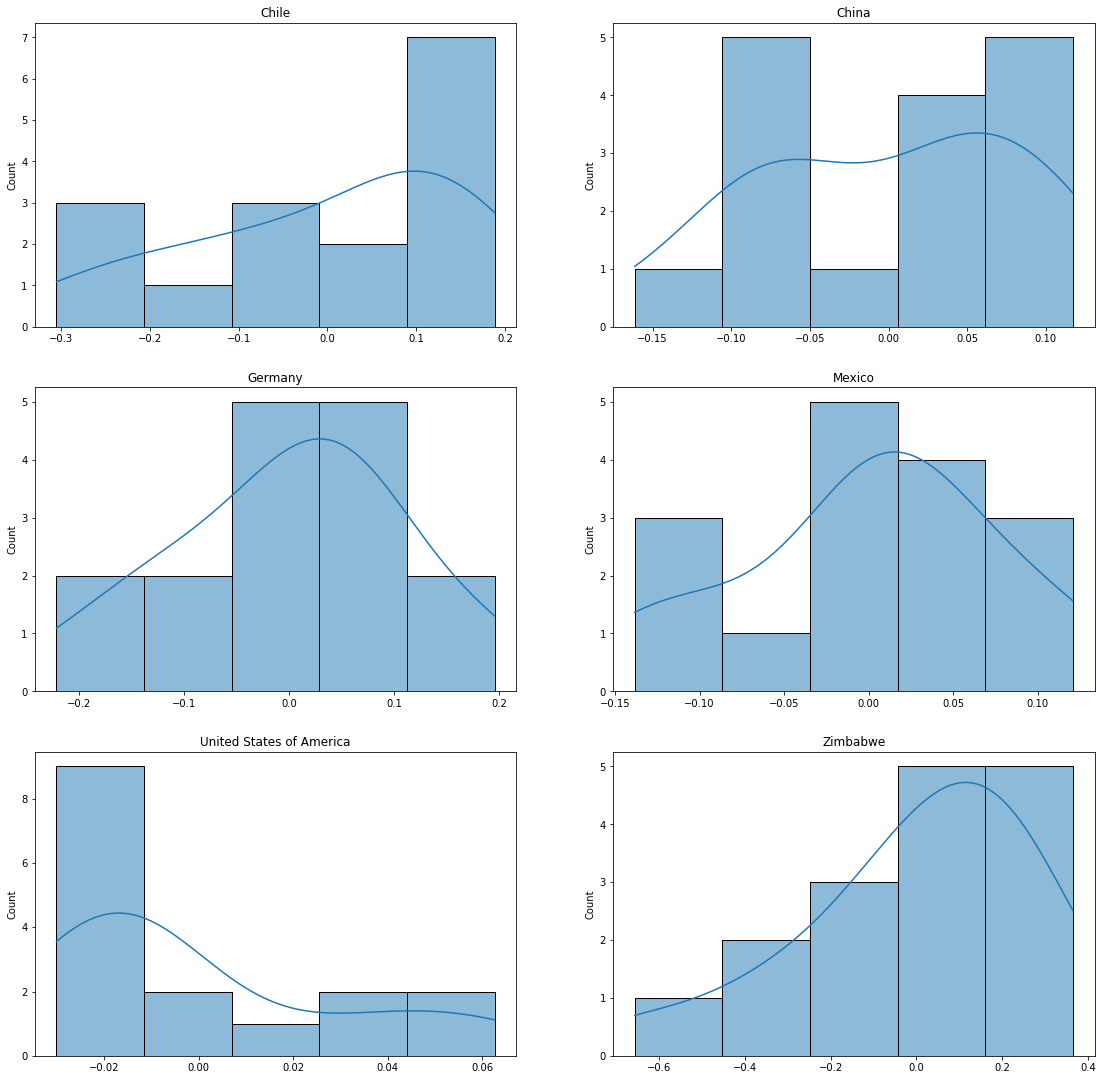

In [118]:
fig, ax = plt.subplots(3, 2, figsize=(19, 19))

row = 0
col = 0

for count, country in enumerate(ind):
    df_subset = df[df.Country == country]
    # log transformation of dependent variable
    df_subset['GDP'] = np.log(df_subset['GDP'])
    model = sm.OLS.from_formula('GDP ~ Year', data=df_subset)
    results = model.fit()
    fitted_values = results.predict(df_subset)
    residuals = df_subset['GDP'] - fitted_values
    
    if count == 0:
        row = 0
        col = 0
    sns.histplot(ax=ax[row, col], x=residuals, kde=True)
    ax[row, col].set_title(country)
    if col == 1:
        col = 0
        row += 1
    else:
        col += 1

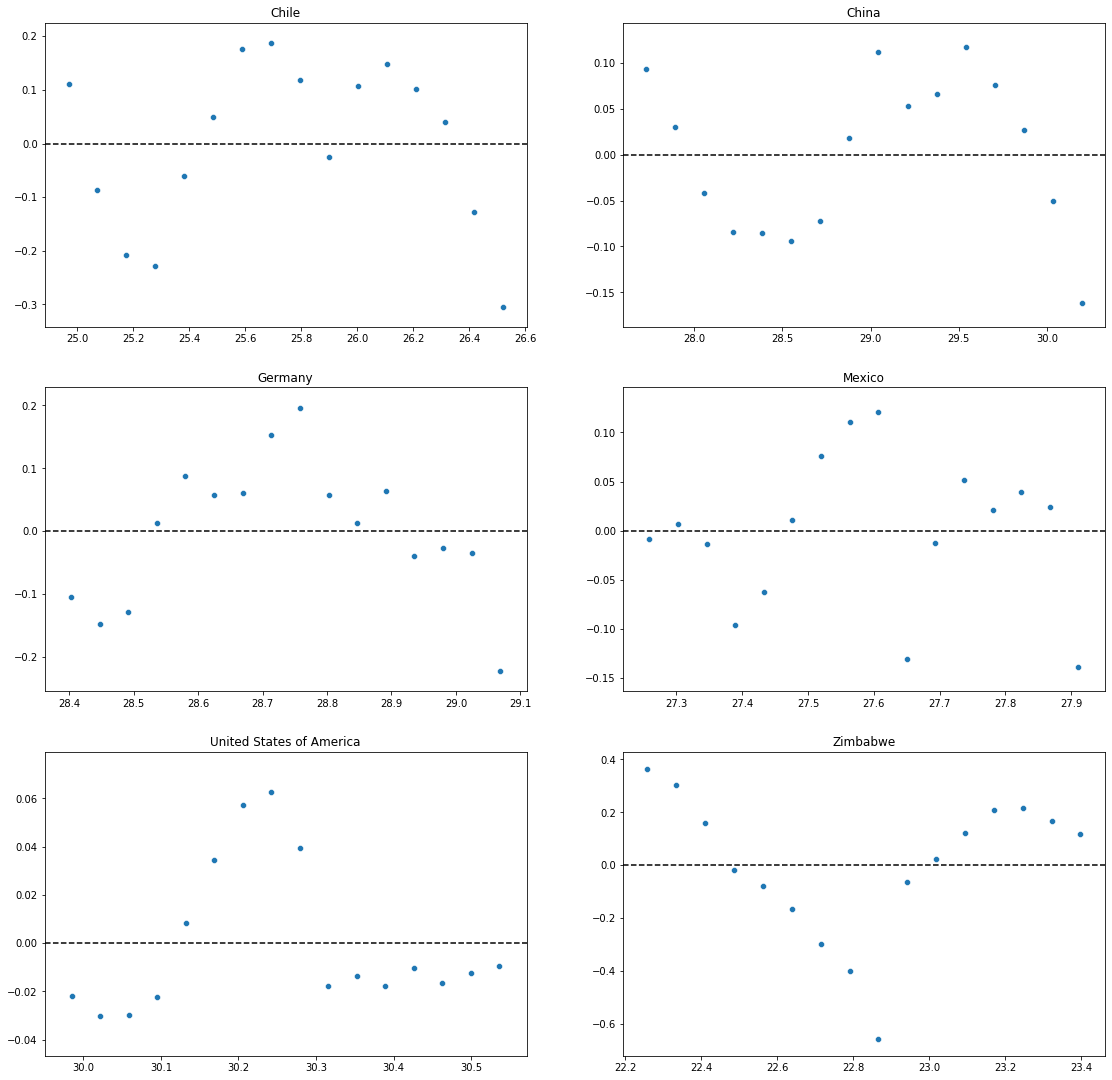

In [119]:
fig, ax = plt.subplots(3, 2, figsize=(19, 19))

row = 0
col = 0

for count, country in enumerate(ind):
    df_subset = df[df.Country == country]
    # log transformation of dependent variable
    df_subset['GDP'] = np.log(df_subset['GDP'])
    model = sm.OLS.from_formula('GDP ~ Year', data=df_subset)
    results = model.fit()
    fitted_values = results.predict(df_subset)
    residuals = df_subset['GDP'] - fitted_values
    
    if count == 0:
        row = 0
        col = 0
    sns.scatterplot(ax=ax[row, col], x=fitted_values, y=residuals)
    ax[row, col].axhline(y=0, color='black', ls='--')
    ax[row, col].set_title(country)
    if col == 1:
        col = 0
        row += 1
    else:
        col += 1
        
# even with log transformation the assumptions look to be violated in some cases, which looks like a limitation of applying
# linear regression data

## Linear regression

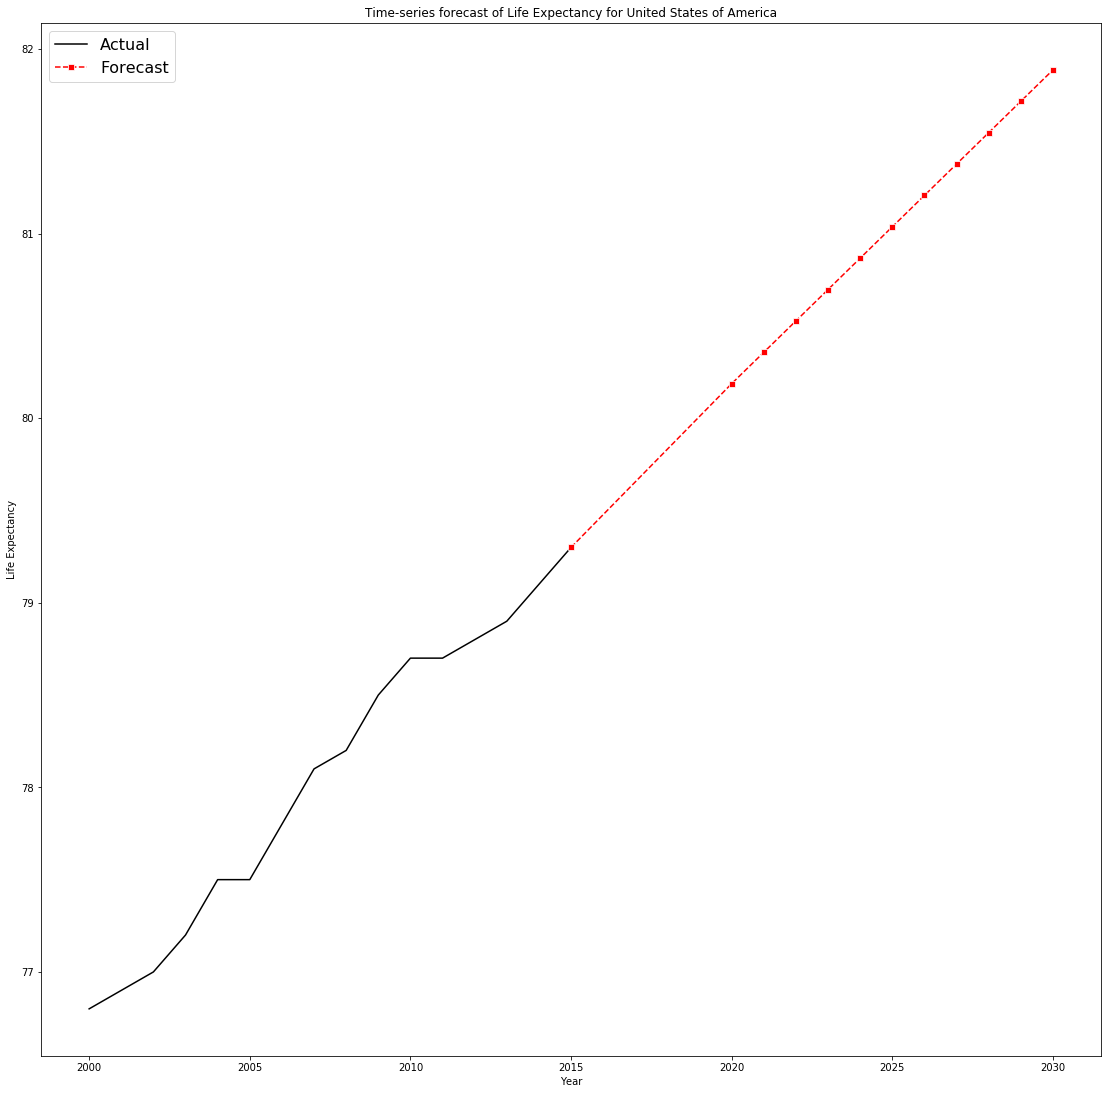

In [222]:
def linear_reg(country, years):
    # set years so that the maximum is 2050, regardless of the input. This is because it's probably unreasonable to expect
    # the life expectancy to increase linearly forever
    years = np.array(years)
    years = np.where(years <= 2050, years, 0)
    years = years[years != 0]
    
    # run linear model of year to GDP for specified country
    
    df_subset = df[df.Country == country]
    gdp_model = sm.OLS.from_formula('GDP ~ Year', data=df_subset)
    gdp_result = gdp_model.fit()
    
    gdp_intercept, gdp_x1 = gdp_result.params
    
    gdp_year = gdp_intercept + gdp_x1 * years    
    
    # run linear model for GDP to life expectancy
    
    model = sm.OLS.from_formula('life_exp ~ GDP', data=df_subset)
    results = model.fit()
    
    intercept, x1 = results.params
    
    # use the prediction of GDP for a given year(s) to predict life expectancy for a given year(s)
        
    le_year = intercept + x1 * gdp_year
    
    years = np.insert(years, 0, 2015)
    le_year = np.insert(le_year, 0, df_subset[df_subset.Year == 2015]['life_exp'])
    
    d = {'Year': years, 'life_exp': le_year}
    predicted_le = pd.DataFrame(data=d)
    
    # plot actual and forecasted life expectancy
      
    plt.figure(figsize=(19, 19))
    
    sns.lineplot(data=df_subset, x='Year', y='life_exp', color='black')
    sns.lineplot(data=predicted_le, x='Year', y='life_exp', ls='--', color='red', marker='s')
    plt.ylabel('Life Expectancy')
    plt.legend(labels=['Actual', 'Forecast'], fontsize=16)
    plt.title(f'Time-series forecast of Life Expectancy for {country}')
    
test = linear_reg('United States of America', [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2060])
test